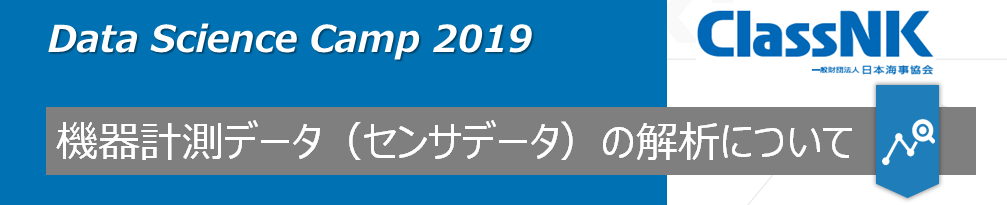

---

<Center><font size=6>第4章　演習2　異常検知</font>

---

<font size=4> サンプルデータを使って異常検知モデルの作製をおこないます。
シリンダ出口の排ガス温度に対して、異常検知モデルの作成を行います。

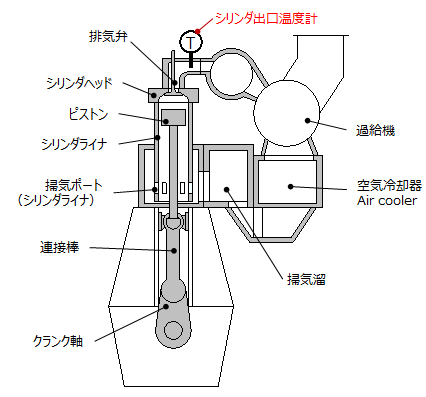

---

# 分析の概念図の作成
<font size=4>本作業は、「シリンダ出口温度の自動異常検知機能の作成」です。</font><br>
<font size=4>どの様にして、異常検知を行うのかを検討し決定していきます。</font>

課題は、「シリンダ出口温度の異常検知」モデルの作製です。
判定軸、要素、要素間の関係を纏めてみましょう。

- データの補正
- データのフィルタリング
- 計測項目間の相関

分析の概念図の例<br>
以降の演習では、本概念図に従って進めていきます。

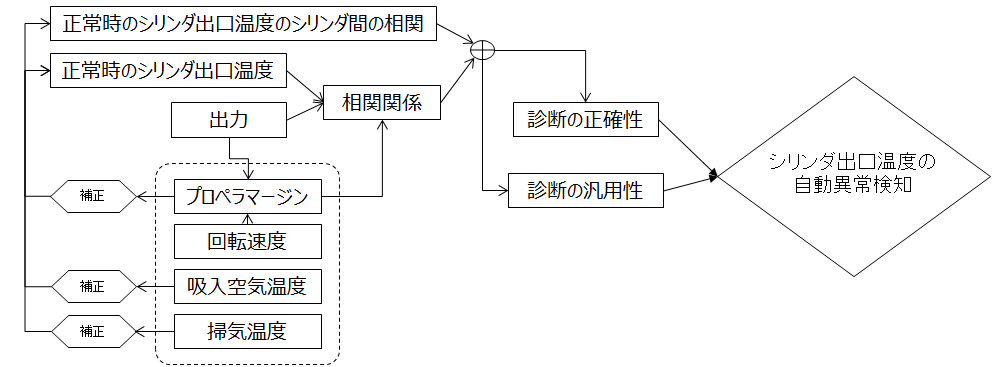

# 解析のためのデータの読み込み、確認

1. データの確認
- データの補正（今回のサンプルデータでは補正済です。）
- データフィルタリング（負荷変動が激しい条件などを除去）
- 正常期間のデータの抜出し

### Pythonの準備
<font size=4>必要なパッケージの読み込み

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import pylab

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
plt.style.use('ggplot')

## データの読み込み、データの概要確認

<font size=4>Pandasのread.csvメソッドにて読み込む。このとき、日時データを日付型を指定。

In [2]:
file_name = 'SampleData_Section4.csv'
df_raw = pd.read_csv(file_name, parse_dates =['DateTime'], na_values='Na')

データの概要をdescribeメソッドで確認。

In [3]:
df_raw.describe()

,SHAFT_OUTPUT,CYL_OUT_Temp_1,CYL_OUT_Temp_2,CYL_OUT_Temp_3,CYL_OUT_Temp_4,CYL_OUT_Temp_5,CYL_OUT_Temp_6
count,20310.000000,20310.000000,20310.000000,20310.000000,20310.000000,20310.000000,20310.000000
mean,10840.998424,369.639193,361.364993,365.493747,364.857213,364.234712,363.309749
std,4026.652909,49.008508,48.298851,50.125483,49.385974,49.046421,49.658052
min,-100.000000,42.000000,44.000000,44.500000,44.000000,43.000000,43.000000
25%,8400.000000,373.000000,362.000000,360.500000,361.000000,364.500000,361.000000
50%,8800.000000,378.500000,368.500000,369.000000,369.500000,372.500000,367.500000
75%,14400.000000,383.500000,378.500000,389.500000,384.000000,381.000000,385.500000
max,20400.000000,483.000000,475.000000,475.000000,485.000000,479.000000,475.000000


 データの先頭行を表示してみる。

In [4]:
df_raw.head()

,DateTime,SHAFT_OUTPUT,CYL_OUT_Temp_1,CYL_OUT_Temp_2,CYL_OUT_Temp_3,CYL_OUT_Temp_4,CYL_OUT_Temp_5,CYL_OUT_Temp_6
0,2001-01-01 00:00:00,0,45.0,47.0,62.0,47.0,47.0,45.0
1,2001-01-01 00:08:00,1700,59.0,62.0,73.0,62.0,67.0,67.0
2,2001-01-01 00:16:00,1400,137.0,136.0,121.0,125.0,126.0,126.0
3,2001-01-01 00:24:00,3700,247.0,240.0,223.0,229.0,238.0,239.0
4,2001-01-01 00:32:00,8700,358.0,351.0,338.0,343.0,350.0,359.0


## データの型式を整える。

数値として扱うべきデータを浮動小数点の型式にする。

In [5]:
for item in df_raw.columns:
    if item != "DateTime":
        df_raw[item] = df_raw[item].astype(float)

df_raw.dtypes

DateTime          datetime64[ns]
SHAFT_OUTPUT             float64
CYL_OUT_Temp_1           float64
CYL_OUT_Temp_2           float64
CYL_OUT_Temp_3           float64
CYL_OUT_Temp_4           float64
CYL_OUT_Temp_5           float64
CYL_OUT_Temp_6           float64
dtype: object

## グラフを書いて視覚化しデータを確認する。

Text(0.5, 1.0, 'Trend graph')

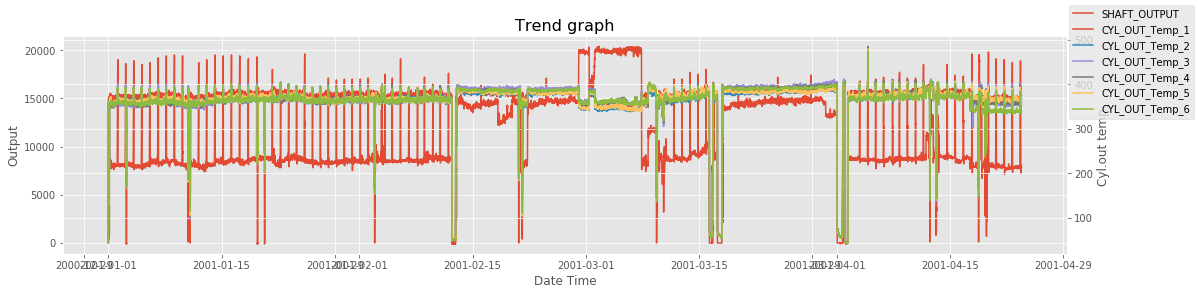

In [9]:
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(111)

for item in df_raw.columns[1:]:
    if item == "SHAFT_OUTPUT":
        ax1.plot(df_raw.DateTime, df_raw[item], label=item)
        ax2=ax1.twinx()
    else:
        ax2.plot(df_raw.DateTime, df_raw[item], label=item)
fig.legend()
plt.grid(True)
ax1.set_xlabel("Date Time")
ax1.set_ylabel("Output")
ax2.set_ylabel("Cyl.out temp.")
plt.title("Trend graph", size=16)

<font size=4> 散布図も描いてみる。

In [10]:
df_raw.columns

Index(['DateTime', 'SHAFT_OUTPUT', 'CYL_OUT_Temp_1', 'CYL_OUT_Temp_2',
       'CYL_OUT_Temp_3', 'CYL_OUT_Temp_4', 'CYL_OUT_Temp_5', 'CYL_OUT_Temp_6'],
      dtype='object')

横軸を軸出力（SHAFT_OUTPUT)とした散布図を作成。

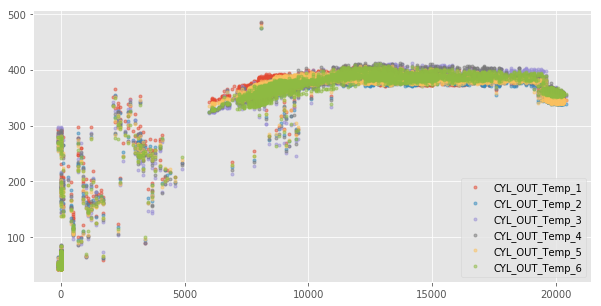

In [11]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
for item in df_raw.columns[1:]:
    if item != "SHAFT_OUTPUT":
        ax1.plot(
            df_raw.SHAFT_OUTPUT,
            df_raw[item],
            "o",
            markersize=3,
            alpha=0.5,
            label=item)
plt.legend()

---
# データの補正について

今回のサンプルデータは、機関の吸入空気温度での補正済です。
ISOで定められている状態の吸入空気温度が25℃の場合と同等になるように、既知の補正式を用いて温度データを補正しています。

<font size=5, color='red'>原動機などでは、外気温度、外気圧力、湿度、冷却水温度などの外環境の相違による差を既知の補正式に基づき補正する必要があります。<br>
    <br>
    今回は演習のため、補正済データとなっていますが、実際の業務では、殆どの場合で補正が必要です。</font>



---
# データクレンジング

## データクレンジングのコンセプトについて

本データは、温度データです。<br>
本講座の前半で学んだとおり、温度データについては取り扱いを注意すべきことがあります。<br>
温度データを扱うときには、非定常な状態の温度を扱うことは避ける必要があります。

---
## フィルタリングのための項目を算出
フィルタリングを行う上で準しておくべき項目を算出します。

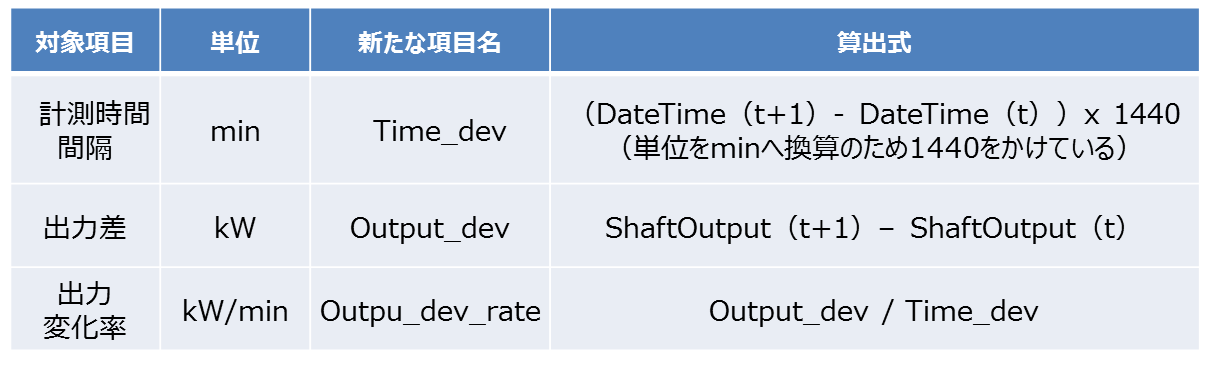

In [12]:
df_raw["Time_dev"] = df_raw.DateTime.diff().astype('m8[m]')
df_raw["Output_dev_rate"] = df_raw.SHAFT_OUTPUT.diff() / df_raw.Time_dev

## フィルタリング条件

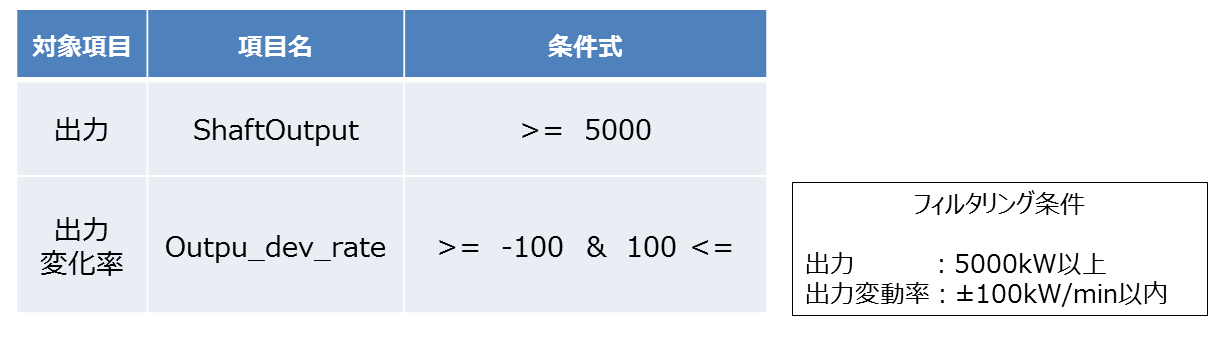

In [13]:
filter_sql = "SHAFT_OUTPUT >= 5000 and  Output_dev_rate >= -100 and Output_dev_rate <=100"
df_sel=df_raw.query(filter_sql).copy()

## グラフを書いて視覚化しデータを確認する。
正常であったことが確認されている期間（2001-2-10 0:0:0 ～ 2001-3-17 23:59:59)の範囲は色をつけて表示。

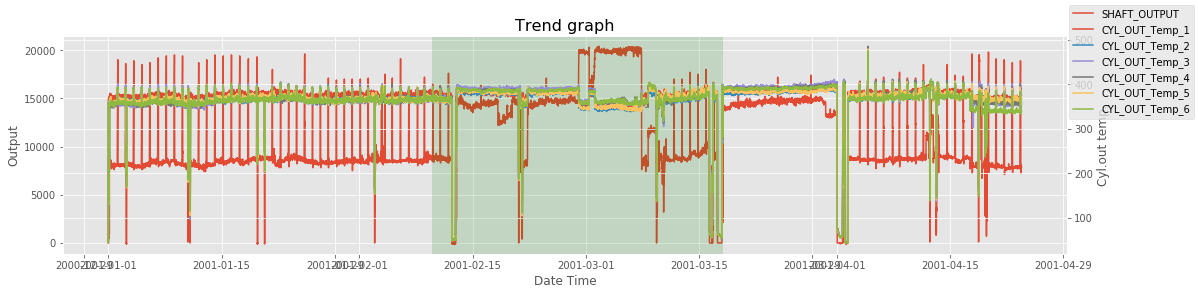

In [14]:
fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(111)

for item in df_raw.columns[1:]:
    if item == "SHAFT_OUTPUT":
        ax1.plot(df_raw.DateTime, df_raw[item], label=item)
        ax2=ax1.twinx()
    elif item != "Output_dev_rate" and item != "Time_dev" :
        ax2.plot(df_raw.DateTime, df_raw[item], label=item)
fig.legend()
plt.grid(True)
ax1.set_xlabel("Date Time")
ax1.set_ylabel("Output")
ax2.set_ylabel("Cyl.out temp.")
plt.title("Trend graph", size=16)

#正常区間を塗る。
pylab.axvspan('2001-2-10 0:0:0', '2001-3-17 23:59:59', facecolor='g', alpha=0.15)

正常状態であったと判っている区間のみを抽出してプロットしてみる。(No.6シリンダのみ扱っている。）

Text(0, 0.5, 'Cyl. out gas temp. (deg.C)')

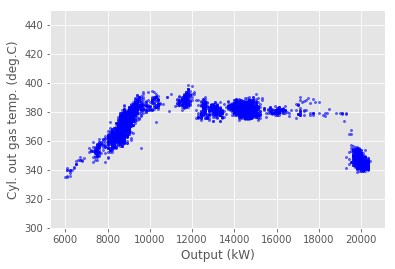

In [15]:
df_normal = df_sel.query("DateTime >'2001-2-10 00:00:00'  and  DateTime < '2001-3-17 23:59:59'").copy()   

plt.plot(df_normal.SHAFT_OUTPUT, df_normal.CYL_OUT_Temp_5, "ob", markersize =2, alpha=0.5)
plt.ylim(300,450)
plt.xlabel("Output (kW)")
plt.ylabel("Cyl. out gas temp. (deg.C)")

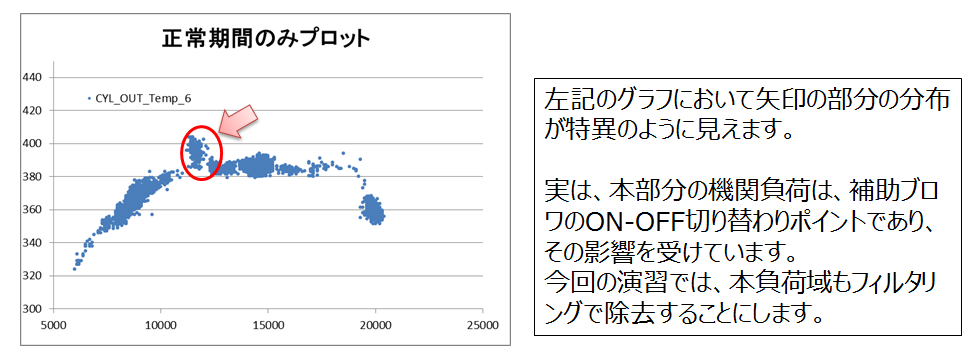

最終フィルタリング条件

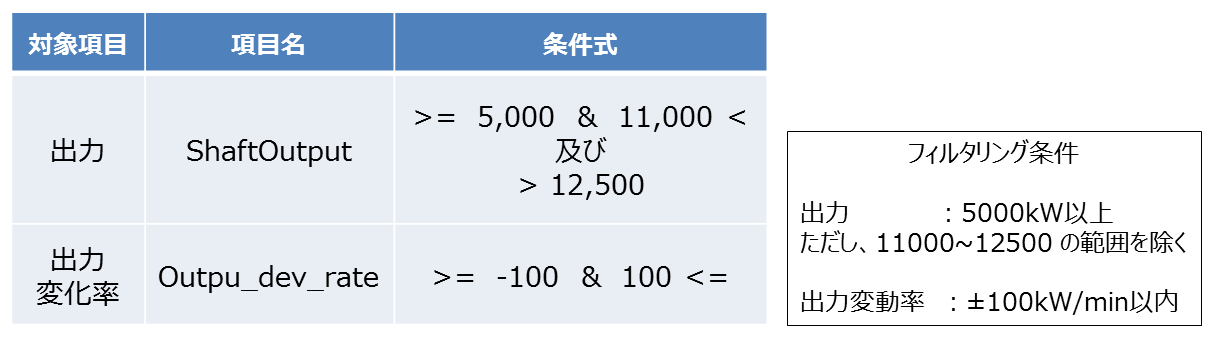

上記フィルタリング条件でデータを抽出し、全期間のデータをプロットしてみる。（下記はNo6シリンダのみプロットした例）

Text(0, 0.5, 'Cyl. out gas temp. (deg.C)')

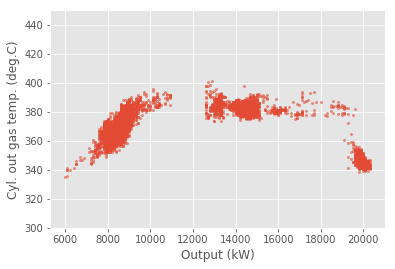

In [16]:
filter_sql = "((SHAFT_OUTPUT >= 5000 and SHAFT_OUTPUT < 11000) or  SHAFT_OUTPUT > 12500) and Output_dev_rate >= -100 and Output_dev_rate <=10"
df_sel_2=df_sel.query(filter_sql).copy()

plt.plot(df_sel_2.SHAFT_OUTPUT, df_sel_2.CYL_OUT_Temp_5, "o", markersize =2, alpha=0.5)
plt.ylim(300,450)
plt.xlabel("Output (kW)")
plt.ylabel("Cyl. out gas temp. (deg.C)")

### 以上まででデータクレンジング終了。　以降で異常検知を進めていく。

---

# 相関に基づいた異常検知

問題を整理した時に挙げた「シリンダ出口温度と出力の相関」に着目した異常検知を行う。<br>

正常であることが確認されている期間のデータから異常検知モデルを作成する。
機器計測データの異常度分析において、シンプルかつ有用である正規分布に基づく異常度を用いる。

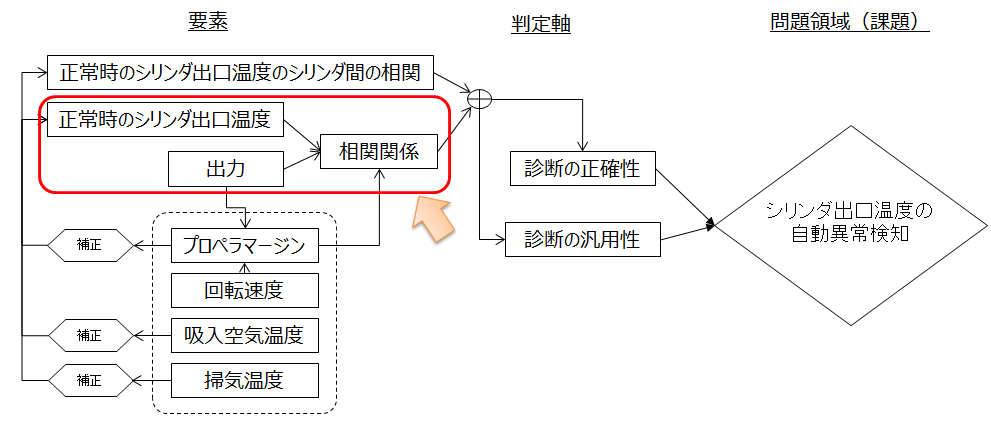

上記でフィルタリング処理したデータから、正常が確認されている期間のデータを抜き出し、プロットして分布を確認する。

In [18]:
df_normal_2 = df_sel_2.query("DateTime >'2001-2-10 00:00:00'  and  DateTime < '2001-3-17 23:59:59'").copy()   

プロットする。

Text(0, 0.5, 'Cyl. out gas temp. (deg.C)')

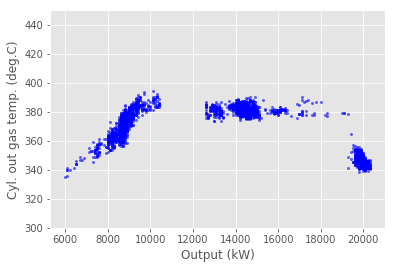

In [19]:
plt.plot(df_normal_2.SHAFT_OUTPUT, df_normal_2.CYL_OUT_Temp_5, "ob", markersize =2, alpha=0.5)
plt.ylim(300,450)
plt.xlabel("Output (kW)")
plt.ylabel("Cyl. out gas temp. (deg.C)")

上記の分布を近似式で表してみる。<br>
本例では、4次式を用いているが、対数近似、スプライン近似など、適した関数を用いた近似をすることにより異常検知精度向上する。<br>
ただし、極端な高次の近似などをおこなうと過学習となり、サンプリングした本データにのみフィットするモデルとなり過敏になりすぎてしまう。

scipyのoptimizeパッケージを使用して近似式を求める。詳細は、https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html 参照。

1. 近似式を関数で定義する。
- curve_fitメソッドに、定義した関数、データを引数として渡す。
- 近似式の係数が得られる。

In [20]:
from scipy import optimize

# 4次式の近似関数を定義
def func_c4(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

#　上記の関数、データをcurve_fitメソッドにて近似式の各係数を求める。
x = df_normal_2.SHAFT_OUTPUT
y = df_normal_2.CYL_OUT_Temp_5
res_c4 = optimize.curve_fit(func_c4, x, y)

#戻り値は2次元配列になっているが、最初の配列が近似式の各係数である。
print(res_c4[0])

[-1.49206687e-14  8.35363239e-10 -1.77816916e-05  1.69006148e-01
 -2.17701892e+02]


上記で求めた近似式に基づいた推定値をプロットしてみる。

Text(0, 0.5, 'Cyl. out gas temp. (deg.C)')

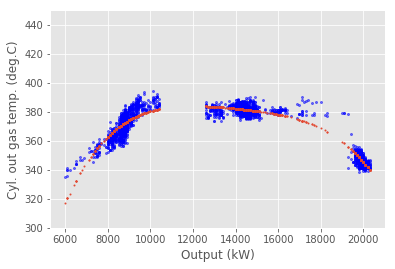

In [21]:
x = df_normal_2.SHAFT_OUTPUT
y_predict = res_c4[0][0]*x**4 + res_c4[0][1]*x**3 + res_c4[0][2]*x**2 + res_c4[0][3]*x + res_c4[0][4]

plt.plot(x, df_normal_2.CYL_OUT_Temp_5, "ob", markersize =2, alpha=0.5)
plt.plot(x, y_predict, "o", markersize=1)
plt.ylim(300,450)
plt.xlabel("Output (kW)")
plt.ylabel("Cyl. out gas temp. (deg.C)")

計測値と推定値（近似線）との差をプロットする。

Text(0, 0.5, 'Distribution (deg.C)')

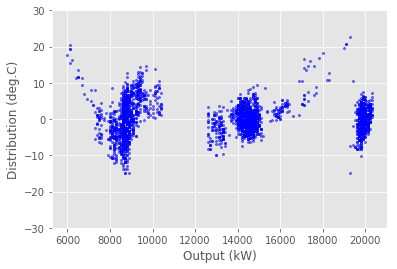

In [22]:
plt.plot(x, df_normal_2.CYL_OUT_Temp_5 - y_predict, "ob", markersize =2, alpha=0.5)
plt.ylim(-30,30)
plt.xlabel("Output (kW)")
plt.ylabel("Distribution (deg.C)")

ヒストグラムをかいてみて、分布が正規分布から大きく逸脱していない事を確認する。

(array([  7.,   2.,  13.,  23.,  24.,  65.,  84., 121., 258., 406., 453.,
        565., 482., 431., 312., 192., 124.,  88.,  51.,  31.,  14.,  12.,
         10.,   5.,   3.,   2.,   2.,   3.,   3.,   1.]),
 array([-14.86440679, -13.61437797, -12.36434915, -11.11432033,
         -9.86429151,  -8.61426269,  -7.36423388,  -6.11420506,
         -4.86417624,  -3.61414742,  -2.3641186 ,  -1.11408978,
          0.13593904,   1.38596786,   2.63599667,   3.88602549,
          5.13605431,   6.38608313,   7.63611195,   8.88614077,
         10.13616959,  11.38619841,  12.63622722,  13.88625604,
         15.13628486,  16.38631368,  17.6363425 ,  18.88637132,
         20.13640014,  21.38642896,  22.63645777]),
 <a list of 30 Patch objects>)

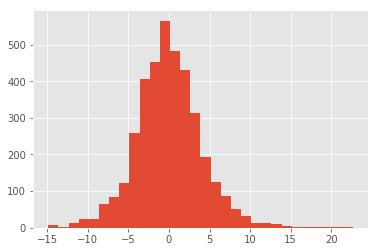

In [23]:
plt.hist(df_normal_2.CYL_OUT_Temp_5 - y_predict, bins=30)

分布は概ね正規分布と見なして問題なさそうである。
上記の分布の標準偏差を求める。

In [24]:
std_6 = np.std(df_normal_2.CYL_OUT_Temp_5 - y_predict)
print(std_6)

4.111175504392049


### ここまでで、異常検知に必要は情報が揃いました。（＝異常検知モデルが出来ました。）

下記の異常度の式を適用して、異常度スコアを求めます。
（本異常度の式の意味については、事前学習資料参照）

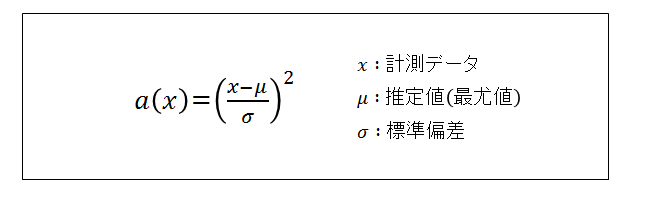

フィルタを通過した全期間の推定値（温度）を求める。（異常度の式のμに相当）

In [25]:
x = df_sel_2.SHAFT_OUTPUT
y_predict = res_c4[0][0]*x**4 + res_c4[0][1]*x**3 + res_c4[0][2]*x**2 + res_c4[0][3]*x + res_c4[0][4]

計測値と推定値の差を求める。（異常度の式の「x-μ」に相当。）

In [26]:
df_dev_m_p =  df_sel_2.CYL_OUT_Temp_5 - y_predict

異常度スコアを求める。

In [27]:
AnomalyScore_6_1 = (df_dev_m_p / std_6)**2

トレンドグラフをプロットしてみる。

Text(0, 0.5, 'Anomaly score')

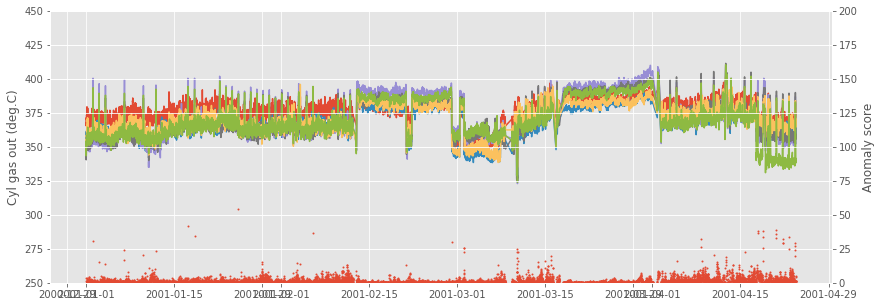

In [28]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(111)
ax2=ax1.twinx()

# 列名に"CYL_OUT_Temp"の文字列が含まれているデータのみを抽出
tmpY = df_sel_2.loc[:, df_sel_2.columns.str.contains("CYL_OUT_Temp")]
ax1.plot(df_sel_2.DateTime ,tmpY, "-", markersize =1)
ax1.set_ylim([250,450])
ax1.set_ylabel("Cyl gas out (deg.C)")

ax2.plot(df_sel_2.DateTime , AnomalyScore_6_1, "o", markersize =1)
ax2.set_ylim([0,200])
ax2.set_ylabel("Anomaly score")

### <font color = 'blue'> ところどころ異常度が上昇している。特に、2001年4月20日頃から異常度が有意に上昇していることが確認できる。</font>

---

## つづいて、偏差に基づいた異常検知を行う。

問題を整理した時に挙げたもう一つの方法である「偏差」に着目した異常検知を行う。<br>

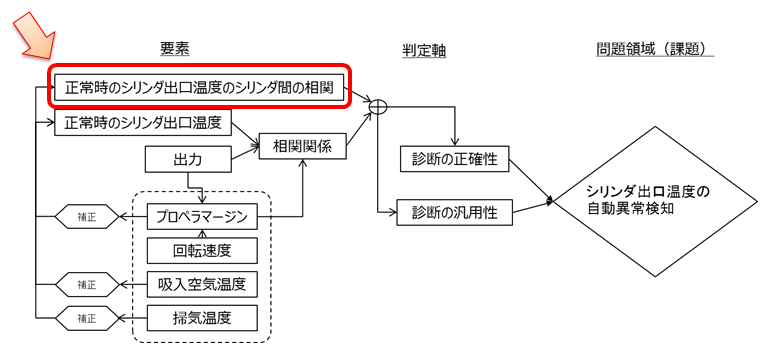

偏差の取り方にはいろいろな方法があるが、今回は以下による手法を行うこととする。<br>
- 自分自身を除く平均値と自分の差を検査対象とする。
- 上記を全シリンダに対して行う。

---

In [5]:
df_sel_2

NameError: name 'df_sel_2' is not defined